# Calling C/R/Python/Fortran code

Compared to Julia,
+ **R** is better at plotting.
+ **Python** has more extensive libraries.
+ **C** and **Fortran** is faster in some applications (cough cough). 

Message: 
> Most Julia users should be writing 100% Julia code, BUT you can run `C`, `Python`, `R` code directly in Julia. 

## Example 1: Writing `R` code in Julia REPL/notebook

+ Example from Douglas Bates' slides [Julia for R programmers](http://pages.stat.wisc.edu/~bates/JuliaForRProgrammers.pdf).
+ Want samples from the joint density: 
$$f(x, y) = kx^2 \exp(xy^2 - y^2 + 2y - 4x), \quad x>0.$$
+ Direct sampling is difficult, so we approximate this with 2 conditional distributions (this is an example of Gibbs sampler)
$$X | Y \sim \Gamma\left( 3, \frac{1}{y^2 + 4} \right)$$
$$Y | X \sim N\left(\frac{1}{1+x}, \frac{1}{2(1 + x)}\right)$$
(Gamma parameters are shape, scale. Normal parameters are mean,variance.)

### Write `R` code in Julia directly using [RCall](https://github.com/JuliaInterop/RCall.jl)

Equivalent for other languages are `PyCall`, `ccall`...etc

In [3]:
using RCall

R"""
library(Matrix)
Rgibbs <- function(N, thin) {
  mat <- matrix(0, nrow=N, ncol=2)
  x <- y <- 0
  for (i in 1:N) {
    for (j in 1:thin) {
      x <- rgamma(1, 3, y * y + 4) # 3rd arg is rate
      y <- rnorm(1, 1 / (x + 1), 1 / sqrt(2 * (x + 1)))
    }
    mat[i,] <- c(x, y)
  }
  mat
}
"""

RObject{ClosSxp}
function (N, thin) 
{
    mat <- matrix(0, nrow = N, ncol = 2)
    x <- y <- 0
    for (i in 1:N) {
        for (j in 1:thin) {
            x <- rgamma(1, 3, y * y + 4)
            y <- rnorm(1, 1/(x + 1), 1/sqrt(2 * (x + 1)))
        }
        mat[i, ] <- c(x, y)
    }
    mat
}


#### `R` timing results with 10000 samples and thinning factor 500:

In [4]:
R"""
system.time(Rgibbs(10000, 500))
"""

RObject{RealSxp}
   user  system elapsed 
 17.252   1.652  18.910 


### Julia version (notice similarity of code)

In [5]:
using Distributions

function jgibbs(N, thin)
    mat = zeros(N, 2)
    x = y = 0.0
    for i in 1:N
        for j in 1:thin
            x = rand(Gamma(3, 1 / (y * y + 4)))
            y = rand(Normal(1 / (x + 1), 1 / sqrt(2(x + 1))))
        end
        mat[i, 1] = x
        mat[i, 2] = y
    end
    mat
end

jgibbs (generic function with 1 method)

In [6]:
jgibbs(100, 5); # warm-up
@elapsed jgibbs(10000, 500)

0.241444906

## Example 2: Put Julia variables into `R` environments 

Transferring variables between `Julia`/`R` environment is easy (`python`/`fortran`/`C` probably the same). Thus, we can isolate specific code that we want to run in other languages easily.

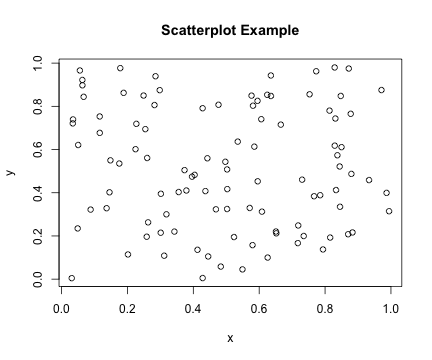

100-element Array{Float64,1}:
 -0.13411339153615764   
 -0.005356538913869224  
 -0.3307030114005569    
 -0.22153007956983806   
 -0.833966920946821     
 -0.04767125153954033   
 -0.5610721347648535    
 -0.07807859816289175   
 -0.23035007777667782   
  0.6670973311576871    
  0.5104226542209465    
 -0.5705390659659195    
 -0.35987197322433273   
  ⋮                     
 -0.44007430790758884   
 -0.5237477651651796    
  0.026207511114783477  
 -0.3072349700458732    
 -0.4015921514396179    
  0.08773746216906186   
 -0.15074781009500926   
 -0.00022914658545070132
  0.018199267004349595  
 -0.8587389339943508    
  0.2416639517870518    
  0.27681961465772487   

In [7]:
using RCall

#generate 100 uniform(0, 1) values in Julia
x = rand(100) 
y = rand(100)

# put variables into R environment
@rput x y

# plot by writing R code
R"""
plot(x, y, main="Scatterplot Example") #saves a file `Rplots.pdf` in current directory
z <- x - y
"""

# get values from R environment back to Julia
@rget z

# Linear Algebra tutorial

Messages:
+ Use built-in functions before implementing yourself. 
+ Almost all standard functions you need are implemented already. Ask Google if you're not sure.
+ Valuable resource: the [linear algebra documention](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/index.html). 

## Example 1: Basic linear algebra routines usually works intuitively.

In [8]:
@show A = rand(2, 2)
@show B = rand(2, 2);

A = rand(2, 2) = [0.241357 0.530018; 0.996786 0.0809222]
B = rand(2, 2) = [0.0730096 0.289288; 0.9195 0.272889]


In [9]:
@show size(A)        # dimension
@show size(A, 1)     # number of rows -> Julia is column major!
@show B[1, 1]        # indexing is with brackets and STARTS WITH 1
@show B[:, 1]        # first column of B
@show view(B, :, 1)  # first column of B without allocating memory
@show A[:, 1]'  # transpose, works on matrices too
@show B * A     # matrix-matrix multiplication
@show [1 2 3]   # row vector
@show [1, 2, 3] # column vector
@show [A[:, 1] B[:, 1]] #concatenate 2 vectors horizontally
@show [A[:, 1]; B[:, 1]] #concatenate 2 vectors vertically
@show A \ [1,2] # solves linear system Ax = b efficiently
@show findall(x -> x .>= 0.3, B); #find entries of B that is >= 0.3
@show fill!(B, 0.0); #fill B with 0

size(A) = (2, 2)
size(A, 1) = 2
B[1, 1] = 0.07300961393834271
B[:, 1] = [0.0730096, 0.9195]
view(B, :, 1) = [0.0730096, 0.9195]
(A[:, 1])' = [0.241357 0.996786]
B * A = [0.30598 0.0621062; 0.49394 0.509434]
[1 2 3] = [1 2 3]
[1, 2, 3] = [1, 2, 3]
[A[:, 1] B[:, 1]] = [0.241357 0.0730096; 0.996786 0.9195]
[A[:, 1]; B[:, 1]] = [0.241357, 0.996786, 0.0730096, 0.9195]
A \ [1, 2] = [1.92442, 1.0104]
findall((x->begin
            #= In[9]:13 =#
            x .>= 0.3
        end), B) = CartesianIndex{2}[CartesianIndex(2, 1)]
fill!(B, 0.0) = [0.0 0.0; 0.0 0.0]


## Example 2: Dot syntax with vectors and matrices

Potentailly confusing, google to make sure when/where to add dots.

In [9]:
@show x = rand(5)
@show y = rand(5)
@show z = rand(5);

x = rand(5) = [0.299436, 0.62417, 0.473909, 0.514266, 0.483782]
y = rand(5) = [0.0431648, 0.162171, 0.303952, 0.67548, 0.766781]
z = rand(5) = [0.787996, 0.478583, 0.60187, 0.736502, 0.245805]


In [10]:
@show x .+ 10      #elementise addition
@show x .* y       #elementise multiplication
@show x .^ 2       #raise power elementise
@show sin.(x)      #apply sin function to x elementize
@show y .> 0.5     #position that is >= 0.5
@show z .= x .+ y; #in-place assignment. z = x + y will incur extra memory allocation 

x .+ 10 = [10.2994, 10.6242, 10.4739, 10.5143, 10.4838]
x .* y = [0.0129251, 0.101222, 0.144045, 0.347376, 0.370955]
x .^ 2 = [0.0896622, 0.389588, 0.22459, 0.264469, 0.234045]
sin.(x) = [0.294982, 0.584424, 0.456368, 0.491896, 0.465131]
y .> 0.5 = Bool[false, false, false, true, true]
z .= x .+ y = [0.342601, 0.786341, 0.777861, 1.18975, 1.25056]


In [11]:
# dots work on user defined functions
function f(a::Float64, b::Float64)
    return sqrt(a^2 + b^2)
end
f.(x, y) # f(x, y) won't work!

5-element Array{Float64,1}:
 0.3025316174597642
 0.6448936420732218
 0.563006551845201 
 0.8489652599456082
 0.9066414620133006

## Example 3: More advanced functions are in LinearAlgebra library

In [13]:
using LinearAlgebra

@show A = rand(2, 2)
@show B = rand(2, 2)
@show C = rand(2, 2);

A = rand(2, 2) = [0.36025 0.227136; 0.118555 0.21467]
B = rand(2, 2) = [0.607503 0.203283; 0.668745 0.809466]
C = rand(2, 2) = [0.678627 0.100758; 0.214867 0.639142]


In [14]:
@show tr(A)
@show det(A)
@show eigvals(A)
@show inv(A)
@show rank(A)
@show lu(A) #LU factorization
@show Transpose(A) # same as A'
@show Diagonal([1, 2]) * A #easily construct diagonal matrix
@show Symmetric(A) * B #easily construct symmetric matrix
@show mul!(C, A, B); # C = A * B in-place multiplication, calls BLAS internally

tr(A) = 0.5749201558851817
det(A) = 0.05040691113440572
eigvals(A) = [0.466977, 0.107943]
inv(A) = [4.25874 -4.50604; -2.35195 7.14684]
rank(A) = 2
lu(A) = LU{Float64,Array{Float64,2}}([0.36025 0.227136; 0.329089 0.139922], [1, 2], 0)
Transpose(A) = [0.36025 0.118555; 0.227136 0.21467]
Diagonal([1, 2]) * A = [0.36025 0.227136; 0.237109 0.42934]
Symmetric(A) * B = [0.370749 0.257091; 0.281545 0.219941]
mul!(C, A, B) = [0.370749 0.257091; 0.215582 0.197868]


# How to benchmark/memory profile

## Example: standardizing columns of matrix to mean 0 variance 1

This is typically required before penalized regression (e.g. lasso, ridge). Mathematically equivalent to 

$$\hat{x}_{ij} = \frac{x_{ij} - \mu(x_j)}{\sigma(x_j)}$$


In [11]:
#naive implementation
function std_test1!(z::Matrix)
    for i in 1:size(z, 2)
        col_mean = mean(z[:, i])
        col_std  = std(z[:, i])
        z[:, i] .= (z[:, i] .- col_mean) ./ col_std
    end
    return z
end

std_test1! (generic function with 1 method)

### @time macro times 1 run of your function

In [12]:
z = rand(10000, 10000)
@time std_test1!(z)
@time std_test1!(z);

  1.629488 seconds (634.26 k allocations: 2.266 GiB, 22.08% gc time)
  1.290219 seconds (60.00 k allocations: 2.237 GiB, 16.61% gc time)


### Use [BenchmarkTool.jl](https://github.com/JuliaCI/BenchmarkTools.jl) package for more robust benchmarking of time/memory

In [13]:
using BenchmarkTools

@benchmark std_test1!(z)

BenchmarkTools.Trial: 
  memory estimate:  2.24 GiB
  allocs estimate:  60000
  --------------
  minimum time:     1.278 s (16.43% GC)
  median time:      1.298 s (16.58% GC)
  mean time:        1.297 s (16.57% GC)
  maximum time:     1.313 s (16.69% GC)
  --------------
  samples:          4
  evals/sample:     1

### For line-by-line profiling, use the [Profile](https://docs.julialang.org/en/v1/manual/profile/index.html#Profiling-1) module.

Tells you how much time is spent on each line. Personally I don't usually find it helpful. 

In [18]:
using Profile

std_test1!(z) #run once to force compile
Profile.clear() 
@profile std_test1!(z)
Profile.print()

1   ./reduce.jl:154; mapreduce_impl(::getfield(Statisti...
886 ./task.jl:259; (::getfield(IJulia, Symbol("##15#1...
 886 ...fjEtl/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  886 ./essentials.jl:696; invokelatest
   886 ./essentials.jl:697; #invokelatest#1
    886 ...rc/execute_request.jl:67; execute_request(::ZMQ.Socket, ::I...
     886 ...c/SoftGlobalScope.jl:218; softscope_include_string(::Modu...
      886 ./boot.jl:319; eval
       885 ./In[18]:5; top-level scope
        885 ...file/src/Profile.jl:25; macro expansion
         292 ./In[15]:4; std_test1!(::Array{Float64,2})
          278 ./abstractarray.jl:905; getindex
           278 ...ltidimensional.jl:597; _getindex
            24  ...ltidimensional.jl:609; _unsafe_getindex(::IndexLin...
             24 ./abstractarray.jl:573; similar
              24 ./array.jl:332; similar
               24 ./boot.jl:403; Type
                24 ./boot.jl:394; Type
            254 ...ltidimensional.jl:611; _unsafe_getindex(::IndexLin...
     

### Memory profiling slightly more tedious
+ First create a `.jl` file containing the code you wish to profile
+ Run code from terminal using `julia --track-allocation=user SCRIPT_NAME.jl`

In [19]:
;cat std_test1.jl

using Profile
using Statistics 

function std_test1!(z::Matrix)
    for i in 1:size(z, 2)
        col_mean = mean(z[:, i])
        col_std  = std(z[:, i])
        z[:, i] .= (z[:, i] .- col_mean) ./ col_std
    end
    return z
end

# wrap everything in functions to avoid global scope 
function run()
	z = rand(10000, 10000)
	std_test1!(z) 	    # force compilation
	Profile.clear_malloc_data() # clear allocation counters
	std_test1!(z) 	    # force compilation
end

run()

In [17]:
;julia --track-allocation=user std_test1.jl

In [18]:
;cat std_test1.jl.mem

        - using Profile
        - using Statistics 
        - 
        - function std_test1!(z::Matrix)
        0     for i in 1:size(z, 2)
        -         col_mean = mean(z[:, i])
        -         col_std  = std(z[:, i])
800800000         z[:, i] .= (z[:, i] .- col_mean) ./ col_std
        -     end
        0     return z
        - end
        - 
        - # wrap everything in functions to avoid global scope 
        - function run()
        - 	z = rand(10000, 10000)
        0 	std_test1!(z) 	    # force compilation
        - 	Profile.clear_malloc_data() # clear allocation counters
        0 	std_test1!(z) 	    # force compilation
        - end
        - 
        - run()


### Use @code_warntype to check to type stability 

Blue means ok, red means not ok. Here the code is all blue, which means no type instability. 

In [19]:
@code_warntype std_test1!(z)

Body::Array{Float64,2}
│╻                size3 1 ─── %1   = (Base.arraysize)(z, 2)::Int64
││╻╷╷╷             Type  │     %2   = (Base.sle_int)(1, %1)::Bool
│││╻                unitrange_last  │            (Base.sub_int)(%1, 1)
││││               │     %4   = (Base.ifelse)(%2, %1, 0)::Int64
││╻╷╷              isempty  │     %5   = (Base.slt_int)(%4, 1)::Bool
││                 └────        goto #3 if not %5
││                 2 ───        goto #4
││                 3 ───        goto #4
│                  4 ┄── %9   = φ (#2 => true, #3 => false)::Bool
│                  │     %10  = φ (#3 => 1)::Int64
│                  │     %11  = φ (#3 => 1)::Int64
│                  │     %12  = (Base.not_int)(%9)::Bool
│                  └────        goto #110 if not %12
│                  5 ┄── %14  = φ (#4 => %10, #109 => %329)::Int64
│                  │     %15  = φ (#4 => %11, #109 => %330)::Int64
│╻╷╷╷             getindex4 │     %16  = (Base.arraysize)(z, 1)::Int64
││┃││              to_indic

### Best code I have

Without using `@inbounds, @simd, @fastmath, @inline` macros... perhaps unique Julia hacks?

In [20]:
function _mean!(z::Matrix, μ::Vector)
    n, q = size(z)
    for j in 1:q
        for i in 1:n
            μ[j] += z[i, j]
        end
        μ[j] /= n
    end
    return μ
end

function _std!(z::Matrix, μ::Vector, σ::Vector)
    n, q = size(z)
    for j in 1:q
        for i in 1:n
            σ[j] += (z[i, j] - μ[j])^2
        end
        σ[j] = 1.0 / sqrt(σ[j] / (n - 1))
    end
    return σ
end

function std_test2!(z::Matrix, μ=zeros(eltype(z), size(z, 2)), σ=zeros(eltype(z), size(z, 2)))
    n, q = size(z)
    _mean!(z, μ)
    _std!(z, μ, σ)

    for j in 1:q, i in 1:n
        z[i, j] = (z[i, j] - μ[j]) * σ[j]
    end
end

std_test2! (generic function with 3 methods)

In [21]:
z = rand(10000, 10000)
μ = zeros(10000)
σ = zeros(10000)
@benchmark std_test2!(z, μ, σ)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     297.251 ms (0.00% GC)
  median time:      301.435 ms (0.00% GC)
  mean time:        301.501 ms (0.00% GC)
  maximum time:     310.872 ms (0.00% GC)
  --------------
  samples:          17
  evals/sample:     1